# Optimal filter tutorial
This script demonstrates how the optimal filtering is typically done. Using a preloaded set pulses and noise data. 

We first load the optimal_filter.py file with the relevant functions:

In [5]:
from optimal_filter import *

Then, we load the two data inputs: a stack of pulses and a noise timestream

In [6]:
import numpy as np
pulses = np.load('pulses.npy')    # MxN array of M pulses of length N
noise = np.load('noise.npy')      # 3 sec of timestream noise data taken at 1 Msample/sec

We then initialize some parameters

In [8]:
pw = 160                # pulse window length
len_onesided = round(pw / 2) + 1
sf = 1e6                # sampling frequency of data
exclude_dc = True       # whether or not to exlude the DC value of the pulse and noise models in the optimal filter
nr_req_segments = 1000  # how many noise segments we want to average for our noise model. It may be that less are returned than desired.
threshold = None        # threshold for pulse detection in the the noise data 

We then compute our pulse and noise models, as well as a normalisation constant

In [9]:
norm_pulse_fft = pulse_model(pulses, pw)
noise_psd, freqs = noise_model(noise, pw, sf, threshold=None, nr_req_segments=1000)
norm_factor = prefactor(norm_pulse_fft, noise_psd)

Now we compute the optimal pulse height for a given pulse. This is done in a for loop for all the pulses that were loaded before. A known array of pulses can be analysed without a for loop, but this illustrates how the mux setup would instantaneously analyse a single pulse.

In [10]:
H = []
for pulse in pulses:
    H.append(mux_filter(pulse, len_onesided, norm_pulse_fft, noise_psd, norm_factor))

Now, we plot some relevant figures:

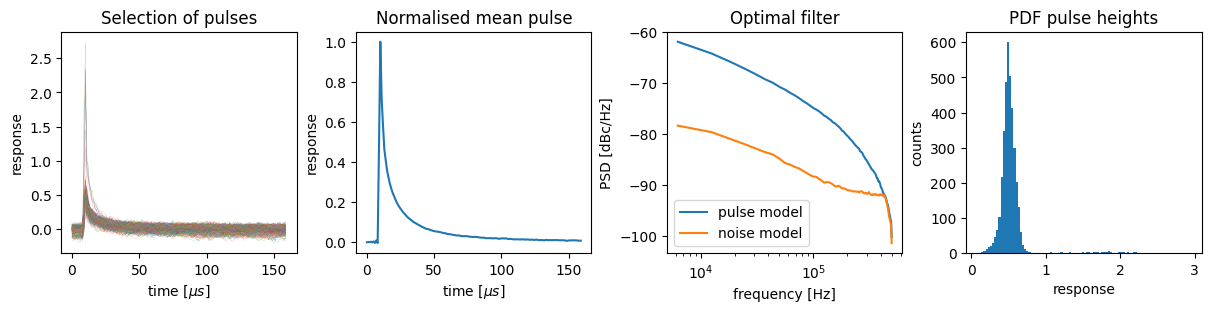

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplot_mosaic('abcd', figsize=(12, 3), constrained_layout=True)
ax = axes['a']
ax.plot(pulses[::10].T, lw=.1)
ax.set_xlabel('time [$\mu s$]')
ax.set_ylabel('response')
ax.set_title('Selection of pulses')

ax = axes['b']
mean_pulse = np.mean(pulses, axis=0)
norm_mean_pulse = mean_pulse / np.amax(mean_pulse)
ax.plot(norm_mean_pulse)
ax.set_xlabel('time [$\mu s$]')
ax.set_ylabel('response')
ax.set_title('Normalised mean pulse')

ax = axes['c']
norm_pulse_psd = 1 / (pw * sf) * np.absolute(norm_pulse_fft)**2
norm_pulse_psd[1:-1] *= 2
_ = ax.semilogx(freqs[1:], 10*np.log10(norm_pulse_psd[1:]), label='pulse model')
_ = ax.semilogx(freqs[1:], 10*np.log10(noise_psd[1:]), label='noise model')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [dBc/Hz]')
ax.set_title('Optimal filter')
ax.legend()

ax = axes['d']
_ = ax.hist(H, bins=100)
ax.set_xlabel('response')
ax.set_ylabel('counts')
_ = ax.set_title('PDF pulse heights')

We can now also plot an original pulse and the optimal filter model together:

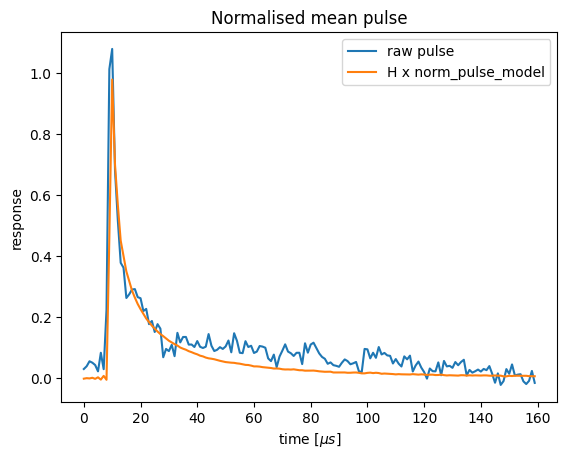

In [12]:
idx = 101                # choose a pulse
fig, ax = plt.subplots()
ax.plot(pulses[idx, :], label='raw pulse')
ax.plot(norm_mean_pulse*H[idx], label='H x norm_pulse_model')
ax.set_xlabel('time [$\mu s$]')
ax.set_ylabel('response')
ax.set_title('Normalised mean pulse')
ax.legend()